In [2]:
from pathlib import Path
import pickle
import warnings

import numpy as np
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import EncoderNormalizer, GroupNormalizer, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import NormalDistributionLoss
from pytorch_forecasting.models.deepar import DeepAR
from pytorch_forecasting.utils import profile
warnings.simplefilter("error", category=SettingWithCopyWarning)


In [3]:
wan_data = pd.read_excel('data_files/WAN_Forecast.xlsx')

In [4]:
data = wan_data.copy()

In [5]:
data.head(5)

,date,wanProvider,fleet,trainName,dataUsage
0,2019-02-27,TDC,6x,5004,0.017193
1,2019-02-27,TDC,6x,5074,0.130114
2,2019-02-27,TDC,7x,7815,0.017145
3,2019-02-28,TDC,6x,5004,12.313495
4,2019-02-28,TDC,6x,5074,22.163222


<AxesSubplot:xlabel='date'>

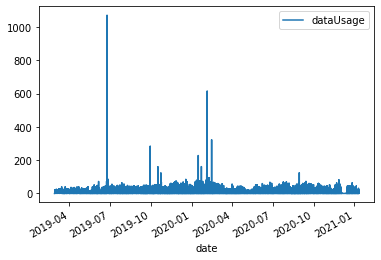

In [6]:
data.plot(x='date', y ='dataUsage')

In [7]:
data['dataUsage'] = data['dataUsage'].apply(lambda x: np.log(x+1))

<AxesSubplot:xlabel='date'>

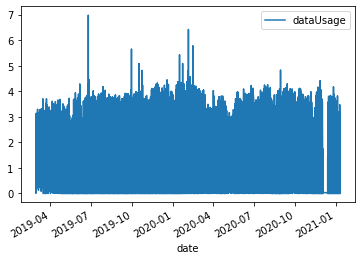

In [8]:
data.plot(x='date', y ='dataUsage')

In [9]:
data['year']=data['date'].dt.year.astype(int)
data['month']=data['date'].dt.month.astype(int) 
data['day']=data['date'].dt.day.astype(int)

data['dayofweek_num']=data['date'].dt.dayofweek.astype(int)
data['dayofweek_name']=data['date'].dt.day_name().astype(str)

data['time_idx'] = pd.Categorical(data['date']).codes
data['trainName'] = data['trainName'].astype(str)
data['static'] = '2'

In [10]:
data['wanProvider'].value_counts()

TDC                    50354
Telenor/Sonofon        33152
TDC DK                 14236
Telenor/Sonofon DK     10958
Telia Mobile SE         3368
T-mobile/Telekom         958
Vodafone D2              951
T-mobile/Telekom DE      522
Vodafone D2 DE           521
Tele2 Sverige AB          85
Telenor (Vodafone)        77
Telia DK                  55
H3G                       32
E-Plus                    10
Telia                      5
Base/KPN                   1
Base/KPN BE                1
Name: wanProvider, dtype: int64

In [11]:
min_samples = 1000
selected_providers = data['wanProvider'].value_counts()[data['wanProvider'].value_counts()>min_samples].index.values
data = data[data['wanProvider'].isin(selected_providers)].reset_index(drop=True)

In [12]:
data.head(5)

,date,wanProvider,fleet,trainName,dataUsage,year,month,day,dayofweek_num,dayofweek_name,time_idx,static
0,2019-02-27,TDC,6x,5004,0.017047,2019,2,27,2,Wednesday,0,2
1,2019-02-27,TDC,6x,5074,0.122319,2019,2,27,2,Wednesday,0,2
2,2019-02-27,TDC,7x,7815,0.017000,2019,2,27,2,Wednesday,0,2
3,2019-02-28,TDC,6x,5004,2.588778,2019,2,28,3,Thursday,1,2
4,2019-02-28,TDC,6x,5074,3.142566,2019,2,28,3,Thursday,1,2


In [31]:
max_prediction_length = 30 # forecast of 6 months
max_encoder_length = 30  # using history of 24 months

training_cutoff = data["time_idx"].max() - max_prediction_length*6

validation = data[lambda x: x.time_idx > training_cutoff]


In [32]:
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="dataUsage",
    group_ids=["wanProvider", "fleet"],
    min_encoder_length=0,  # allowing predictions without history
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    categorical_encoders={k: NaNLabelEncoder().fit(data[k]) for k in ["wanProvider", "fleet"]},
    static_categoricals=["wanProvider", "fleet"],
    time_varying_known_categoricals=["dayofweek_name"],
    # group of categorical variables can be treated as one variable
    time_varying_known_reals=[
        "time_idx","month","year","day","dayofweek_num",
    ],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "dataUsage"
    ],
    target_normalizer=GroupNormalizer(
        groups=["wanProvider", "fleet"]
    ),  # use softplus with beta=1.0 and normalize by group
    add_relative_time_idx = False,  # add as feature
    add_target_scales=True,  # add as feature
    add_encoder_length=True,  # add as feature
    allow_missing_timesteps=True,
    
)

In [33]:
validation = TimeSeriesDataSet.from_dataset(
    training, validation, predict=False, stop_randomization=True
)

In [34]:
batch_size = 64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)


In [35]:
early_stop_callback = EarlyStopping(monitor="train_loss", min_delta=1e-4, patience=5, verbose=False, mode="min")
lr_logger = LearningRateMonitor()

In [36]:
trainer = pl.Trainer(
    max_epochs=10,
    gpus=0,
    gradient_clip_val=0.1,
    limit_train_batches=30,
    limit_val_batches=3,
    # fast_dev_run=True,
    # logger=logger,
    # profiler=True,
    callbacks=[lr_logger, early_stop_callback],
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [37]:
print(len(training), len(validation))
print(len(train_dataloader), len(val_dataloader))

121107 99714
1892 1559


In [38]:
deepar = DeepAR.from_dataset(
    training,
    learning_rate=0.1,
    hidden_size=32,
    dropout=0.1,
    loss=NormalDistributionLoss(),
    log_interval=10,
    log_val_interval=3,
    # reduce_on_plateau_patience=3,
)
print(f"Number of parameters in network: {deepar.size()/1e3:.1f}k")


Number of parameters in network: 15.9k


In [39]:
trainer.fit(
    deepar,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 100   
3 | rnn                    | LSTM                   | 15.7 K
4 | distribution_projector | Linear                 | 66    
------------------------------------------------------------------
15.9 K    Trainable params
0         Non-trainable params
15.9 K    Total params
0.064     Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Naveed\Anaconda3\envs\ml\lib\site-packages\pytorch_lightning\trainer\data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


C:\Users\Naveed\Anaconda3\envs\ml\lib\site-packages\pytorch_lightning\trainer\data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
C:\Users\Naveed\Anaconda3\envs\ml\lib\site-packages\pytorch_lightning\trainer\data_loading.py:433: UserWarning: The number of training samples (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Epoch 0:   3%|▎         | 1/33 [05:17<2:49:15, 317.37s/it, loss=4.11, v_num=7, train_loss_step=4.110]

In [52]:
max_prediction_length = 30*6  # forecast of 6 months
max_encoder_length = 30*18  # using history of 24 months
training_cutoff = data["date"].max() - max_prediction_length
training = TimeSeriesDataSet(
    data[lambda x: x.date <= training_cutoff],
    time_idx="date",
    target="dataUsage",
    group_ids=["wanProvider", "fleet", "trainName"],
    min_encoder_length=0,  # allowing predictions without history
max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["wanProvider", "fleet", "trainName"],
time_varying_known_categoricals=["month"],
    # group of categorical variables can be treated as one variable
    time_varying_known_reals=[
        "date",
    ],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "dataUsage"
    ],
    target_normalizer=GroupNormalizer(
        groups=["wanProvider", "fleet", "trainName"]
    ),  # use softplus with beta=1.0 and normalize by group
    add_relative_time_idx = False,  # add as feature
    add_target_scales=True,  # add as feature
    add_encoder_length=True,  # add as feature
    allow_missing_timesteps=True
)
# creating validation set (predict=True) which means to predict the
# last max_prediction_length points in time for each series
validation = TimeSeriesDataSet.from_dataset(
    training, data, predict=True, stop_randomization=True
)
# create dataloaders for model
batch_size = 64
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=0
) 


Epoch 0:  23%|██▎       | 7/31 [19:20<1:06:17, 165.74s/it, loss=1.9, v_num=1, train_loss_step=2.010]
                                                              

C:\Users\Naveed\Anaconda3\envs\ml\lib\site-packages\pytorch_forecasting\data\encoders.py:621: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,


C:\Users\Naveed\Anaconda3\envs\ml\lib\site-packages\pytorch_forecasting\data\timeseries.py:1244: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 302 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__wanProvider': 'Base/KPN', '__group_id__fleet': '8x', '__group_id__trainName': '5635'}, {'__group_id__wanProvider': 'Base/KPN BE', '__group_id__fleet': '1x', '__group_id__trainName': '7824'}, {'__group_id__wanProvider': 'H3G', '__group_id__fleet': '6x', '__group_id__trainName': '5078'}, {'__group_id__wanProvider': 'H3G', '__group_id__fleet': '6x', '__group_id__trainName': '5080'}, {'__group_id__wanProvider': 'H3G', '__group_id__fleet': '6x', '__group_id__trainName': '5081'}, {'__group_id__wanProvider': 'H3G', '__group_id__fleet': '6x', '__group_id__trainName': '5083'}, {'__group_id__wanProvider': 'H3G', '__group

In [53]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=False, mode="min")
lr_logger = LearningRateMonitor()

trainer = pl.Trainer(
    max_epochs=10,
    gpus=0,
    gradient_clip_val=0.1,
    limit_train_batches=30,
    limit_val_batches=3,
    # fast_dev_run=True,
    # logger=logger,
    # profiler=True,
    callbacks=[lr_logger, early_stop_callback],
)


deepar = DeepAR.from_dataset(
    training,
    learning_rate=0.1,
    hidden_size=32,
    dropout=0.1,
    loss=NormalDistributionLoss(),
    log_interval=10,
    log_val_interval=3,
    # reduce_on_plateau_patience=3,
)
print(f"Number of parameters in network: {deepar.size()/1e3:.1f}k")

# # find optimal learning rate
# deepar.hparams.log_interval = -1
# deepar.hparams.log_val_interval = -1
# trainer.limit_train_batches = 1.0
# res = trainer.tuner.lr_find(
#     deepar, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5, max_lr=1e2
# )

# print(f"suggested learning rate: {res.suggestion()}")
# fig = res.plot(show=True, suggest=True)
# fig.show()
# deepar.hparams.learning_rate = res.suggestion()

torch.set_num_threads(10)
trainer.fit(
    deepar,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

# calcualte mean absolute error on validation set
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
predictions = deepar.predict(val_dataloader)
print(f"Mean absolute error of model: {(actuals - predictions).abs().mean()}")


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 15.6 K
3 | rnn                    | LSTM                   | 21.4 K
4 | distribution_projector | Linear                 | 66    
------------------------------------------------------------------
37.0 K    Trainable params
0         Non-trainable params
37.0 K    Total params
0.148     Total estimated model params size (MB)


Number of parameters in network: 37.0k
Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Naveed\Anaconda3\envs\ml\lib\site-packages\pytorch_lightning\trainer\data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Validation sanity check:  50%|█████     | 1/2 [00:04<00:04,  4.08s/it]

C:\Users\Naveed\Anaconda3\envs\ml\lib\site-packages\pytorch_lightning\utilities\data.py:60: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 640. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"


ValueError: Expected parameter loc (Tensor of shape (409, 180)) of distribution Normal(loc: torch.Size([409, 180]), scale: torch.Size([409, 180])) to satisfy the constraint Real(), but found invalid values:
tensor([[0.0460, 0.0460, 0.0460,  ..., 0.0460, 0.0460, 0.0460],
        [0.0520, 0.0520, 0.0520,  ..., 0.0520, 0.0520, 0.0520],
        [0.0640, 0.0640, 0.0640,  ..., 0.0640, 0.0640, 0.0640],
        ...,
        [2.5971, 2.5971, 2.5971,  ..., 2.5973, 2.5973, 2.5973],
        [3.9235, 3.9235, 3.9235,  ..., 3.9238, 3.9238, 3.9238],
        [3.1750, 3.1750, 3.1750,  ..., 3.1752, 3.1752, 3.1752]])